In [1]:
import os
import json
import numpy as np
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import itertools
import seaborn as sns
import pickle
from scipy import stats

from models_optimized import HierarchicalPlasticRNN
from task import WhatAndWhereTask



plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 20})
plt.rcParams['image.interpolation']='nearest'

plt.rc('axes', linewidth=1)
plt.rc('xtick.major', width=2, size=8)
plt.rc('ytick.major', width=2, size=8)
plt.rc('xtick.minor', width=1, size=4)
plt.rc('ytick.minor', width=1, size=4)
plt.rc('mathtext', default='regular')


In [2]:
exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/what_where_analysis/what-where-task-analysis/rnn/exp'
figure_data_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/what_where_analysis/what-where-task-analysis/figures'

model_array_dir = [f'simple_setup_{i}' for i in range(1,9)]
# model_array_dir = [f'test{i}' for i in range(1,9)]

f = open(os.path.join(exp_dir, model_array_dir[0], 'args.json'), 'r')
args = json.load(f)
print('loaded args')

what_where_task = WhatAndWhereTask(args['dt'], args['stim_dims'])

input_config = {
    'fixation': (1, [0]),
    'stimulus': (args['stim_dims']*2, [0]),
    'reward': (2, [0]), 
    'action_chosen': (2, [0]), 
}

output_config = {
    'action': (2, [0]), # left, right
    'stimulus': (args['stim_dims'], [0]),
    'block_type': (2, [0]), # where or what block
}

total_trial_time = what_where_task.times['ITI']+\
                    what_where_task.times['fixation_time']+\
                    what_where_task.times['stim_time']+\
                    what_where_task.times['choice_reward_time']

model_specs = {'input_config': input_config, 'hidden_size': args['hidden_size'], 'output_config': output_config,
                'num_areas': args['num_areas'], 'plastic': args['plas_type']=='all', 'activation': args['activ_func'],
                'dt_x': args['dt'], 'dt_w': total_trial_time, 'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 
                'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (1, 1)}

device = torch.device('cpu')
E_SIZE = int(args['hidden_size']*args['e_prop'])

all_models = []
for model_dir in model_array_dir:
    model = HierarchicalPlasticRNN(**model_specs)
    state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.tar'), 
                            map_location=torch.device('cpu'))['model_state_dict']
    print(model.load_state_dict(state_dict))
    all_models.append(model)
    print(f'model at {model_dir} loaded successfully')

loaded args
<All keys matched successfully>
model at simple_setup_1 loaded successfully
<All keys matched successfully>
model at simple_setup_2 loaded successfully
<All keys matched successfully>
model at simple_setup_3 loaded successfully
<All keys matched successfully>
model at simple_setup_4 loaded successfully


/scratch/f005d7d/ipykernel_120812/2925397733.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.ta

<All keys matched successfully>
model at simple_setup_5 loaded successfully
<All keys matched successfully>
model at simple_setup_6 loaded successfully
<All keys matched successfully>
model at simple_setup_7 loaded successfully
<All keys matched successfully>
model at simple_setup_8 loaded successfully


In [3]:
test_activities_dir = '/dartfs/rc/lab/S/SoltaniA/f005d7d/what_where_analysis/rnn_test_activities/test_activities_with_perturbations.pkl'
with open(test_activities_dir, 'rb') as f:
    all_saved_states = pickle.load(f)
print('loaded previous results')


loaded previous results


In [4]:
def stay_probs(results_dict):
    # calculate the probability of staying with the same location and stimulus choice given previous trial's reward outcomes
    # results_dict: dict of results from the model
    # return: dict of stay probabilities

    num_blocks, num_trials, _ = results_dict['reward'].shape
    stay_probs = {
        'what_unrewarded_loc': [],
        'what_rewarded_loc': [],
        'where_unrewarded_loc': [],
        'where_rewarded_loc': [],
        'what_unrewarded_img': [],
        'what_rewarded_img': [],
        'where_unrewarded_img': [],
        'where_rewarded_img': [],
    }
    all_block_stay_probs = np.nan*np.empty((num_blocks, 4)) # [unrewarded, rewarded] X [loc, img]

    for block_idx in range(num_blocks):
        block_type = results_dict['block_type'][block_idx]
        reward = results_dict['reward'][block_idx]
        img_chosen = results_dict['img_chosen'][block_idx]
        loc_chosen = results_dict['loc_chosen'][block_idx]

        reward_prev = np.isclose(reward[:-1], 1).squeeze()
        unreward_prev = np.isclose(reward[:-1], 0).squeeze()

        if block_type == 0:
            stay_probs['where_unrewarded_loc'].append(np.mean(loc_chosen[1:][unreward_prev] == loc_chosen[:-1][unreward_prev]))
            stay_probs['where_unrewarded_img'].append(np.mean(img_chosen[1:][unreward_prev] == img_chosen[:-1][unreward_prev]))
            stay_probs['where_rewarded_loc'].append(np.mean(loc_chosen[1:][reward_prev] == loc_chosen[:-1][reward_prev]))
            stay_probs['where_rewarded_img'].append(np.mean(img_chosen[1:][reward_prev] == img_chosen[:-1][reward_prev]))
            all_block_stay_probs[block_idx] = [stay_probs['where_unrewarded_loc'][-1], 
                                              stay_probs['where_unrewarded_img'][-1],
                                              stay_probs['where_rewarded_loc'][-1],
                                              stay_probs['where_rewarded_img'][-1]]
        elif block_type == 1:
            stay_probs['what_unrewarded_loc'].append(np.mean(loc_chosen[1:][unreward_prev] == loc_chosen[:-1][unreward_prev]))
            stay_probs['what_unrewarded_img'].append(np.mean(img_chosen[1:][unreward_prev] == img_chosen[:-1][unreward_prev]))
            stay_probs['what_rewarded_loc'].append(np.mean(loc_chosen[1:][reward_prev] == loc_chosen[:-1][reward_prev]))
            stay_probs['what_rewarded_img'].append(np.mean(img_chosen[1:][reward_prev] == img_chosen[:-1][reward_prev]))
            all_block_stay_probs[block_idx] = [stay_probs['what_unrewarded_loc'][-1], 
                                              stay_probs['what_unrewarded_img'][-1],
                                              stay_probs['what_rewarded_loc'][-1],
                                              stay_probs['what_rewarded_img'][-1]]
        else:
            raise ValueError
            


    return stay_probs, all_block_stay_probs



In [6]:
_, all_block_stay_probs_aligned = stay_probs(all_saved_states['aligned_perturbation'])
all_stay_probs, all_block_stay_probs_orthogonal = stay_probs(all_saved_states['orthogonal_perturbation'])


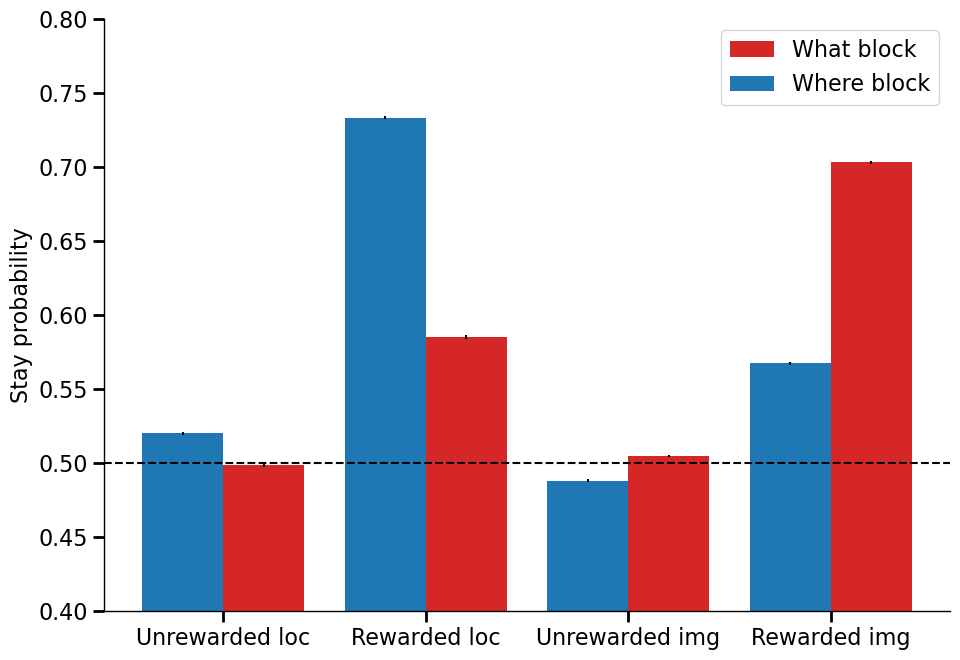

In [7]:
# plot the average stay probabilities in bar plot

stay_probs_what_blocks = [
    [np.mean(all_stay_probs[k]), np.std(all_stay_probs[k])/np.sqrt(len(all_stay_probs[k]))] for k in all_stay_probs.keys() if 'what' in k
]

stay_probs_where_blocks = [
    [np.mean(all_stay_probs[k]), np.std(all_stay_probs[k])/np.sqrt(len(all_stay_probs[k]))] for k in all_stay_probs.keys() if 'where' in k
]

stay_probs_what_blocks = np.array(stay_probs_what_blocks)
stay_probs_where_blocks = np.array(stay_probs_where_blocks)

plt.bar(np.arange(len(stay_probs_what_blocks))+0.2, stay_probs_what_blocks[:,0], color='tab:red', label='What block', width=0.4)
plt.errorbar(np.arange(len(stay_probs_what_blocks))+0.2, stay_probs_what_blocks[:,0], 
             yerr=stay_probs_what_blocks[:,1], color='black', fmt='none')
plt.bar(np.arange(len(stay_probs_where_blocks))-0.2, stay_probs_where_blocks[:,0], color='tab:blue', label='Where block', width=0.4)
plt.errorbar(np.arange(len(stay_probs_where_blocks))-0.2, stay_probs_where_blocks[:,0], 
             yerr=stay_probs_where_blocks[:,1], color='black', fmt='none')
plt.axhline(0.5, ls='--', c='k')

plt.xticks(np.arange(len(stay_probs_what_blocks)), ['Unrewarded loc', 'Rewarded loc', 'Unrewarded img', 'Rewarded img'], fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Stay probability', fontsize=16)
plt.legend(fontsize=16)
plt.ylim([0.4, 0.8])

plt.tight_layout()

sns.despine()

plt.show()






In [8]:
dr_loc_aligned = all_block_stay_probs_aligned[:,2]-all_block_stay_probs_aligned[:,0]
dr_img_aligned = all_block_stay_probs_aligned[:,3]-all_block_stay_probs_aligned[:,1]

dr_loc_orthogonal = all_block_stay_probs_orthogonal[:,2]-all_block_stay_probs_orthogonal[:,0]
dr_img_orthogonal = all_block_stay_probs_orthogonal[:,3]-all_block_stay_probs_orthogonal[:,1]

SignificanceResult(statistic=0.029430114924294783, pvalue=0.027641759685704967) SignificanceResult(statistic=-0.06359901882000786, pvalue=1.9066536578261945e-06)
SignificanceResult(statistic=0.00587098035518746, pvalue=0.6604806546138972) SignificanceResult(statistic=0.007044247896693867, pvalue=0.5981712946668507)
SignificanceResult(statistic=0.12641799040457802, pvalue=2.1755495067531817e-21) SignificanceResult(statistic=-0.14698603983871286, pvalue=2.0259485300417244e-28)
SignificanceResult(statistic=0.0005410086754211737, pvalue=0.9677133637432027) SignificanceResult(statistic=0.0252314095154907, pvalue=0.059022615495513076)
SignificanceResult(statistic=0.13364824697027866, pvalue=9.745991887479383e-24) SignificanceResult(statistic=-0.20420779849969203, pvalue=8.663362632243665e-54)
SignificanceResult(statistic=-0.01588216198507298, pvalue=0.23470665332647234) SignificanceResult(statistic=-0.012530177977422816, pvalue=0.3485013534882321)


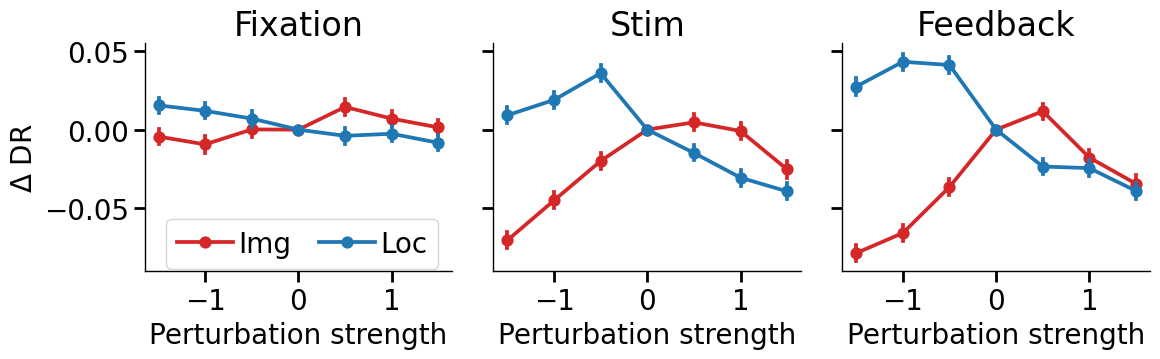

In [78]:


phase_names = ['Fixation', 'Stim', 'Feedback']

fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12, 4))

for phase in [1,2,3]:
    
    num_pert_strengths = 7
    
    phase_mask = all_saved_states['aligned_perturbation']['perturbation_phase']==phase
    block_type_mask = all_saved_states['aligned_perturbation']['block_type']>-1
    trial_mask = phase_mask & block_type_mask
    
    
    delta_dr_img_aligned = dr_img_aligned[trial_mask].reshape((-1, num_pert_strengths))
    delta_dr_img_aligned -= delta_dr_img_aligned[:,num_pert_strengths//2][:,None]
    delta_dr_img_aligned = delta_dr_img_aligned.reshape(-1)
    
    delta_dr_loc_aligned = dr_loc_aligned[trial_mask].reshape((-1, num_pert_strengths))
    delta_dr_loc_aligned -= delta_dr_loc_aligned[:,num_pert_strengths//2][:,None]
    delta_dr_loc_aligned = delta_dr_loc_aligned.reshape(-1)
    
    xxx = np.concatenate([all_saved_states['aligned_perturbation']['perturbation_strength'][trial_mask], 
                          all_saved_states['aligned_perturbation']['perturbation_strength'][trial_mask]])
    
    yyy = np.concatenate([delta_dr_img_aligned, delta_dr_loc_aligned])
    
    hue = ['Img']*delta_dr_img_aligned.shape[0]+['Loc']*delta_dr_loc_aligned.shape[0]
    
    sns.pointplot(x=xxx, y=yyy, hue=hue, ax=axes[phase-1], legend=True if phase==1 else False, 
                 palette=['tab:red', 'tab:blue'], estimator='mean', errorbar='se',
                 native_scale=True)
#     sns.violinplot(x=xxx, y=yyy, hue=hue, ax=axes[phase-1], legend=False, 
#                    palette=['tab:red', 'tab:blue'], split=True)
    
    print(stats.spearmanr(all_saved_states['orthogonal_perturbation']['perturbation_strength'][trial_mask],
                         delta_dr_img_aligned),
         stats.spearmanr(all_saved_states['orthogonal_perturbation']['perturbation_strength'][trial_mask],
                         delta_dr_loc_aligned),)

    delta_dr_img_orthogonal = dr_img_orthogonal[trial_mask].reshape((-1, num_pert_strengths))
    delta_dr_img_orthogonal -= delta_dr_img_orthogonal[:,num_pert_strengths//2][:,None]
    delta_dr_img_orthogonal = delta_dr_img_orthogonal.reshape(-1)
    
    delta_dr_loc_orthogonal = dr_loc_orthogonal[trial_mask].reshape((-1, num_pert_strengths))
    delta_dr_loc_orthogonal -= delta_dr_loc_orthogonal[:,num_pert_strengths//2][:,None]
    delta_dr_loc_orthogonal = delta_dr_loc_orthogonal.reshape(-1)
    
    xxx = np.concatenate([all_saved_states['orthogonal_perturbation']['perturbation_strength'][trial_mask], 
                          all_saved_states['orthogonal_perturbation']['perturbation_strength'][trial_mask]])
    
    yyy = np.concatenate([delta_dr_img_orthogonal, delta_dr_loc_orthogonal])
    
#     sns.pointplot(x=xxx, y=yyy, hue=hue, ax=axes[phase-1], legend=False, 
#                    palette=['grey', 'lightgrey'], errorbar='se', native_scale=True)

    print(stats.spearmanr(all_saved_states['orthogonal_perturbation']['perturbation_strength'][trial_mask],
                         delta_dr_img_orthogonal),
         stats.spearmanr(all_saved_states['orthogonal_perturbation']['perturbation_strength'][trial_mask],
                         delta_dr_loc_orthogonal),)
    

    axes[phase-1].set_ylabel(r'$\Delta$ DR')
    axes[phase-1].set_xlabel('Perturbation strength')
    axes[phase-1].set_title(phase_names[phase-1])
    
    
sns.move_legend(axes[0], "lower right", bbox_to_anchor=(1.0,-0.05), 
                columnspacing=1, handletextpad=0.2, ncols=2)    

sns.despine()
fig.tight_layout()
plt.savefig(os.path.join(figure_data_dir, "RNN_perturb_block_type.pdf"), bbox_inches='tight')
